# Predicting Used Car Prices

Develop a robust machine learning model to accurately predict used car prices in the market. By utilizing this model, the company aims to improve pricing recommendations, optimize inventory management, and help both buyers and sellers make informed decisions.

# Import Libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Load the Data

In [51]:
# Load the dataset
df = pd.read_csv('usedCars.csv')

In [52]:
df.head()

,Id,Company,Model,Variant,FuelType,Colour,Kilometer,BodyStyle,TransmissionType,ManufactureDate,ModelYear,CngKit,Price,Owner,DealerState,DealerName,City,Warranty,QualityScore
0,555675,MARUTI SUZUKI,CELERIO(2017-2019),1.0 ZXI AMT O,PETROL,Silver,33197,HATCHBACK,NaN,01-02-2018,2018,NaN,5.75 Lakhs,1st Owner,Karnataka,Top Gear Cars,Bangalore,1,7.8
1,556383,MARUTI SUZUKI,ALTO,LXI,PETROL,Red,10322,HATCHBACK,Manual,01-03-2021,2021,NaN,4.35 Lakhs,1st Owner,Karnataka,Renew 4 u Automobiles PVT Ltd,Bangalore,1,8.3
2,556422,HYUNDAI,GRAND I10,1.2 KAPPA ASTA,PETROL,Grey,37889,HATCHBACK,Manual,01-03-2015,2015,NaN,4.7 Lakhs,1st Owner,Karnataka,Anant Cars Auto Pvt Ltd,Bangalore,1,7.9
3,556771,TATA,NEXON,XT PLUS,PETROL,A Blue,13106,HATCHBACK,NaN,01-08-2020,2020,NaN,9.9 Lakhs,1st Owner,Karnataka,Adeep Motors,Bangalore,1,8.1
4,559619,FORD,FIGO,EXI DURATORQ 1.4,DIESEL,Silver,104614,HATCHBACK,Manual,01-11-2010,2010,NaN,2.7 Lakhs,2nd Owner,Karnataka,Zippy Automart,Bangalore,0,7.5


# Data preprocessing

In [53]:
df.dtypes

,0
Id,int64
Company,object
Model,object
Variant,object
FuelType,object
Colour,object
Kilometer,int64
BodyStyle,object
TransmissionType,object
ManufactureDate,object


In [54]:
df.isnull().sum()

,0
Id,0
Company,0
Model,0
Variant,0
FuelType,1
Colour,0
Kilometer,0
BodyStyle,0
TransmissionType,714
ManufactureDate,0


In [55]:
df.duplicated().sum()

np.int64(0)

In [56]:
df.describe()

,Id,Kilometer,ModelYear,Warranty,QualityScore
count,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,568156.542293,52807.187970,2016.864662,0.738722,7.770207
std,16438.139974,33840.296979,2.996786,0.439538,0.719717
min,525978.000000,101.000000,2003.000000,0.000000,0.000000
25%,555321.500000,32113.500000,2015.000000,0.000000,7.500000
50%,572753.000000,49432.000000,2017.000000,1.000000,7.800000
75%,583072.750000,68828.500000,2019.000000,1.000000,8.100000
max,589122.000000,640000.000000,2023.000000,1.000000,9.400000


In [57]:
# Convert 'ManufactureDate' to datetime
df['ManufactureDate'] = pd.to_datetime(df['ManufactureDate'], errors='coerce')

In [58]:
# Data preprocessing: Convert 'Price' from 'X Lakhs' to float
def price_to_float(price_str):
    if isinstance(price_str, str):
        return float(price_str.replace(' Lakhs', '').replace(',', ''))
    return price_str

In [59]:
df['Price'] = df['Price'].apply(price_to_float)

In [60]:
df.loc[df['Price'] == 95000, 'Price'] = 0.95

In [61]:
# Fill missing values in categorical columns
categorical_cols = [
    'Company', 'Model', 'Variant', 'FuelType', 'Colour',
    'BodyStyle', 'TransmissionType', 'Owner', 'DealerState', 'City', 'CngKit'
]
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

# Univariate Analysis

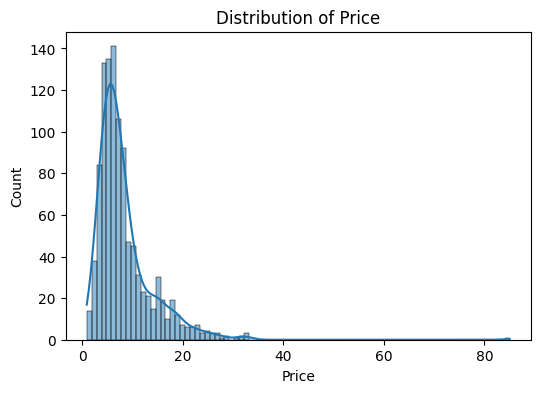

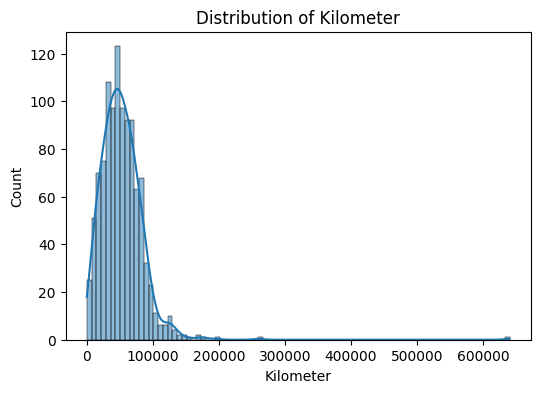

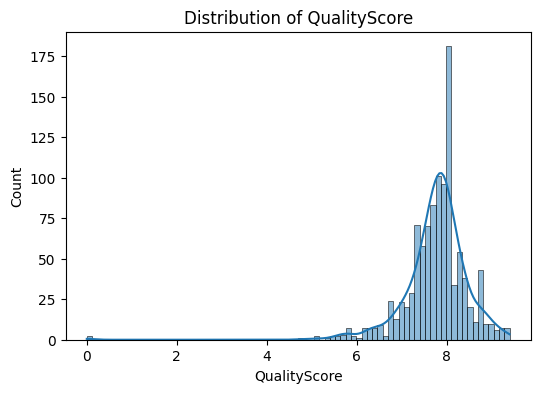

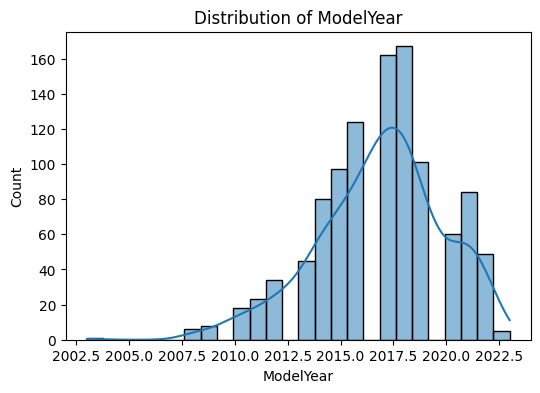

In [62]:
# Numerical features
numerical_cols = ['Price', 'Kilometer', 'QualityScore', 'ModelYear']

# Plot histograms for numerical features
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

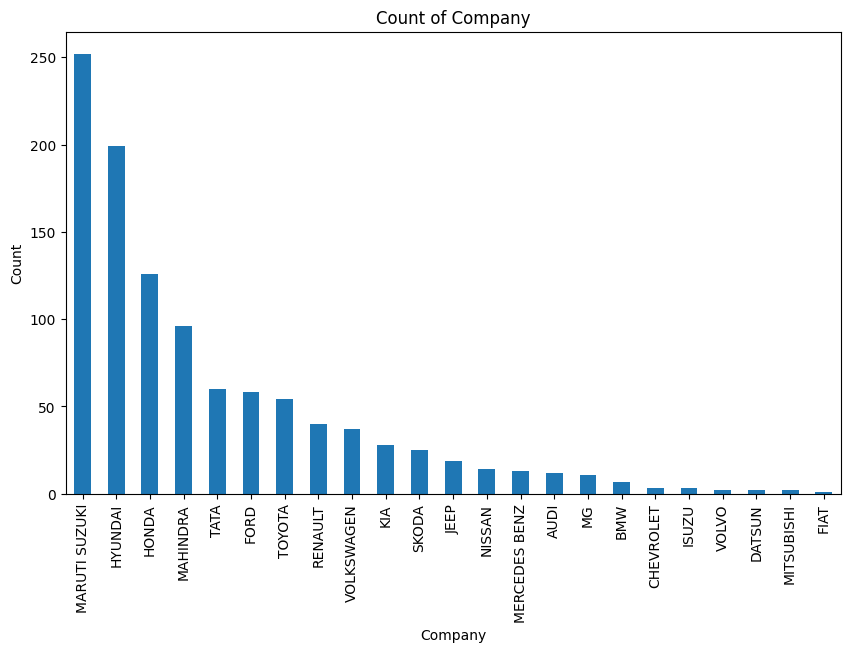

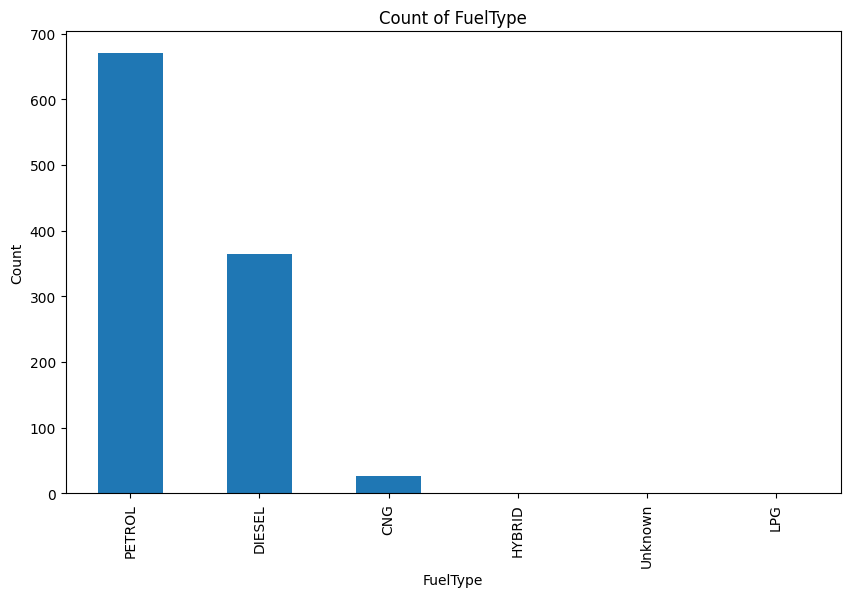

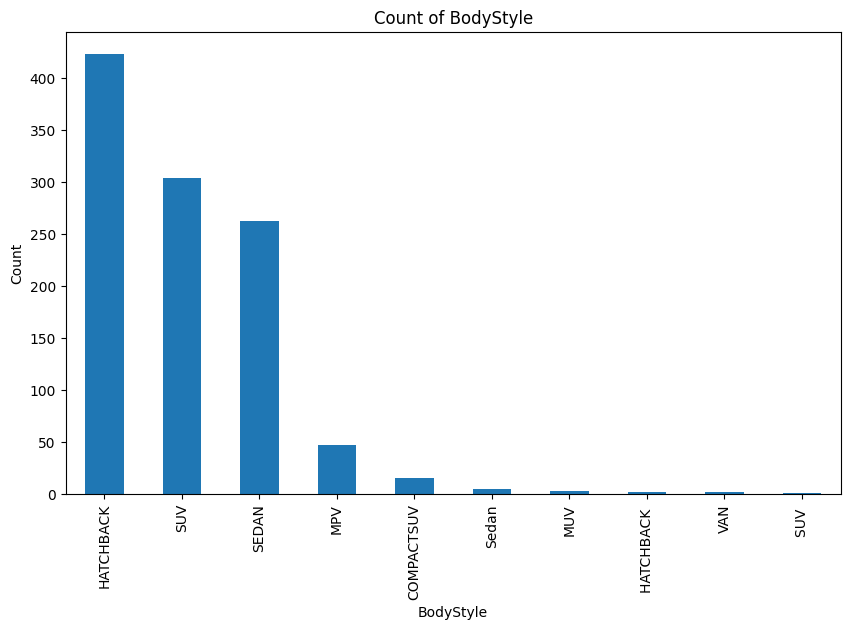

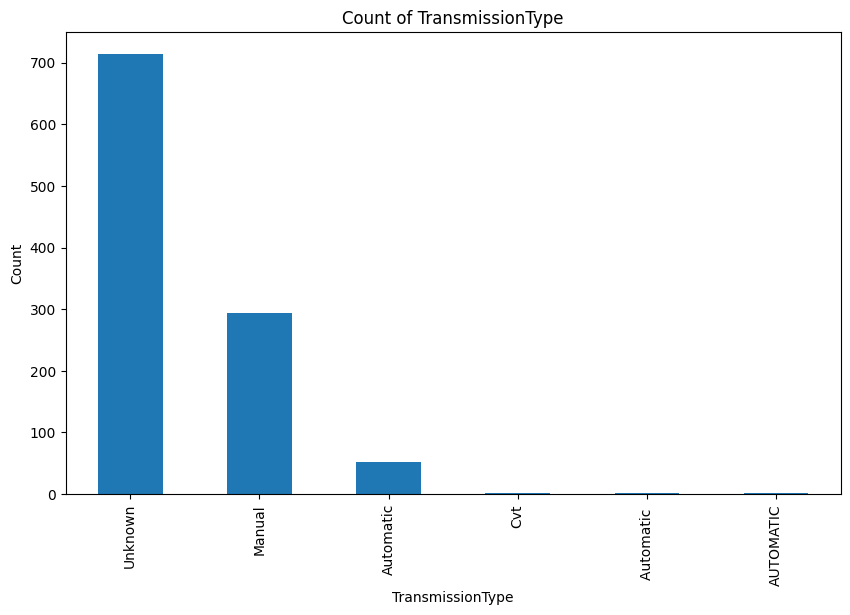

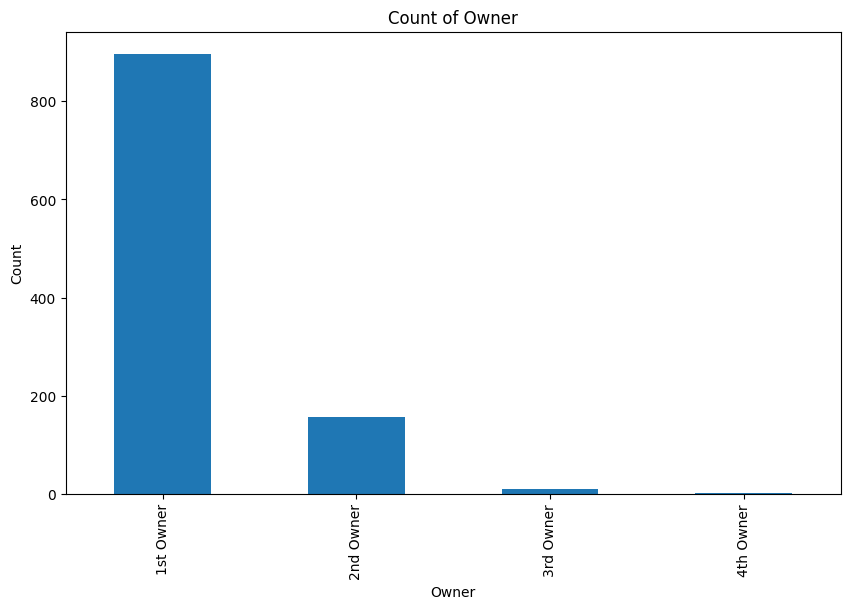

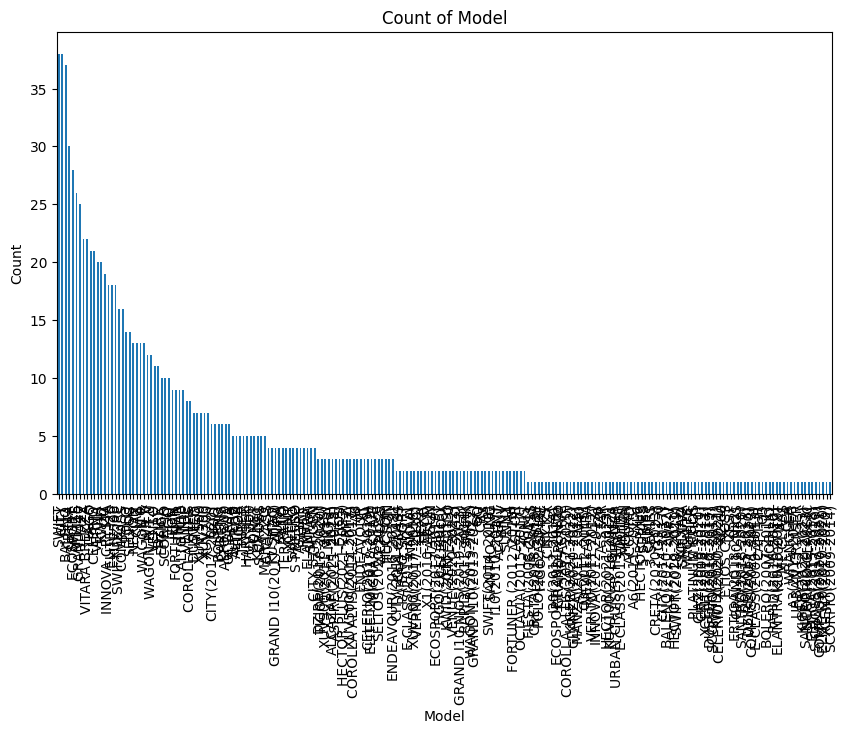

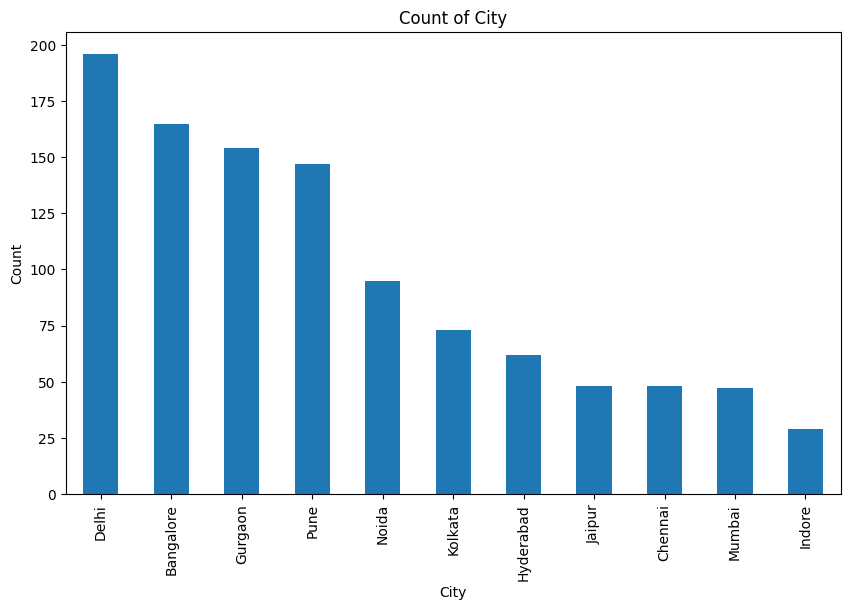

In [63]:
# Categorical features
categorical_cols = ['Company', 'FuelType', 'BodyStyle', 'TransmissionType', 'Owner', 'Model', 'City']

# Plot bar plots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(10,6))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Count of {col}')
    plt.ylabel('Count')
    plt.show()

# Bivariate Analysis

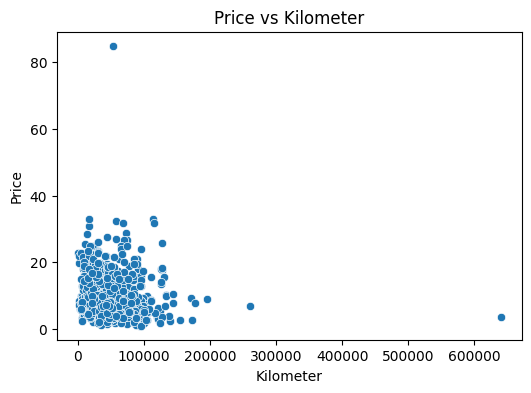

In [64]:
# Scatter plot: Price vs Kilometer
plt.figure(figsize=(6,4))
sns.scatterplot(x='Kilometer', y='Price', data=df)
plt.title('Price vs Kilometer')
plt.show()

# Detecting and removing Outliers

In univariate and bivariate analysis detecting some outliers in Price and Kilometers, removing that outliers using interquartile range.

In [65]:
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]
print(f"Interquartile Range (IQR) of Total Amount: {IQR}")

Interquartile Range (IQR) of Total Amount: 5.0


In [66]:
Q1 = df["Kilometer"].quantile(0.25)
Q3 = df["Kilometer"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Kilometer'] >= lower_bound) & (df['Kilometer'] <= upper_bound)]
print(f"Interquartile Range (IQR) of Total Amount: {IQR}")

Interquartile Range (IQR) of Total Amount: 36044.5


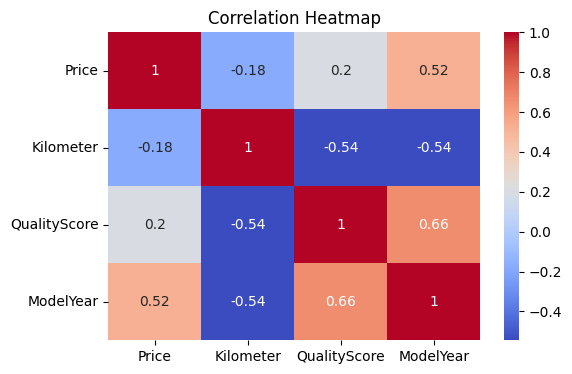

In [67]:
# Correlation heatmap for numerical features
plt.figure(figsize=(6,4))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

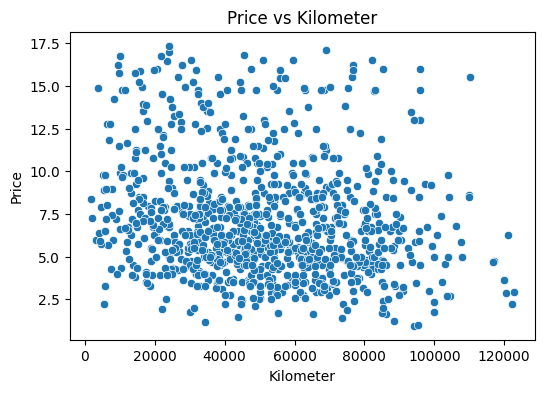

In [68]:
# Scatter plot: Price vs Kilometer
plt.figure(figsize=(6,4))
sns.scatterplot(x='Kilometer', y='Price', data=df)
plt.title('Price vs Kilometer')
plt.show()

# Feature Engineering

In [69]:
# Calculate car age as of 2025
# Get the current year dynamically
current_year = datetime.now().year
df['CarAge'] = current_year - df['ModelYear']
print(df[['ModelYear', 'CarAge']].head())

   ModelYear  CarAge
0       2018       7
1       2021       4
2       2015      10
3       2020       5
4       2010      15


In [70]:
# One-hot encoding for categorical features
df_encoded = pd.get_dummies(df[categorical_cols])
numeric_cols = ['Kilometer', 'ModelYear', 'Warranty', 'QualityScore', 'CarAge']

# Define features and target

In [71]:
# Select features and target
X = pd.concat([df_encoded, df[numeric_cols]], axis=1)
y = df['Price']

# Train-test split

In [72]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build the ML Model

# Linear regression

In [73]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [74]:
# Predictions
lr_pred = lr.predict(X_test)

In [75]:
r2 = r2_score(y_test, lr_pred)
mse = mean_squared_error(y_test, lr_pred)
mae = mean_absolute_error(y_test, lr_pred)
print(f'Linear Regression Results :')
print(f"R² Score: {r2:.2f}")
print(f"Mean Squared Error: {mse}")
print(f"Mean absolute Error: {mae}")
print('RMSE:', np.sqrt(mean_squared_error(y_test, lr_pred)))

Linear Regression Results :
R² Score: 0.85
Mean Squared Error: 1.7448180971885783
Mean absolute Error: 0.8763697542970713
RMSE: 1.3209156283383805


# Decision Tree

In [76]:
# Desicion tree regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [77]:
# Prediction
dt_pred = dt.predict(X_test)

In [78]:
r2 = r2_score(y_test, dt_pred)
mse = mean_squared_error(y_test, dt_pred)
mae = mean_absolute_error(y_test, dt_pred)
print(f'Decision tree Results :')
print(f"R² Score: {r2:.2f}")
print(f"Mean Squared Error: {mse}")
print(f"Mean absolute Error: {mae}")
print('RMSE:', np.sqrt(mean_squared_error(y_test, dt_pred)))

Decision tree Results :
R² Score: 0.67
Mean Squared Error: 3.9415015625000005
Mean absolute Error: 1.3453645833333336
RMSE: 1.9853215262269235


# Random forest

In [79]:
# Random forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [80]:
# Prediction
rf_pred = rf.predict(X_test)

In [81]:
r2 = r2_score(y_test, rf_pred)
mse = mean_squared_error(y_test, rf_pred)
mae = mean_absolute_error(y_test, rf_pred)
print(f'Random forest Results :')
print(f"R² Score: {r2:.2f}")
print(f"Mean Squared Error: {mse}")
print(f"Mean absolute Error: {mae}")
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf_pred)))

Random forest Results :
R² Score: 0.79
Mean Squared Error: 2.556140346614583
Mean absolute Error: 1.0775244791666665
RMSE: 1.5987934033559754


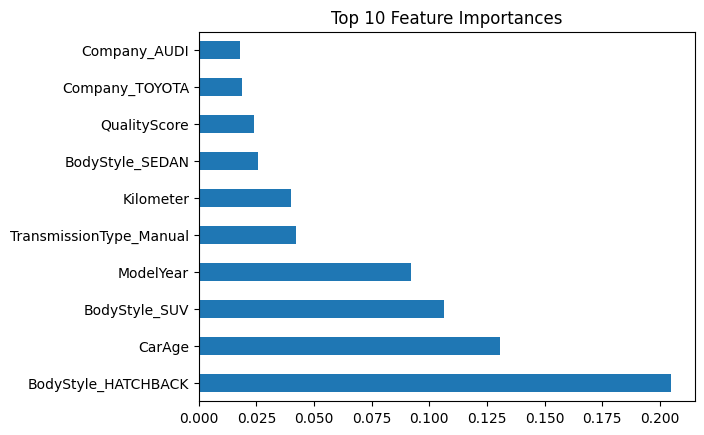

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feat_imp.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()

# XGBoost Regressor

In [83]:
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [84]:
categorical_cols = [
    'Company', 'Model', 'Variant', 'FuelType', 'Colour',
    'BodyStyle', 'TransmissionType', 'Owner', 'DealerState', 'City', 'CngKit'
]
numeric_cols = ['Kilometer', 'ModelYear', 'Warranty', 'QualityScore', 'CarAge']

In [85]:
# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])


In [86]:
X = df.drop(['Price'], axis = 1)
y = df['Price']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
# Pipeline with XGBoost
model = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

In [89]:
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Company', 'Model',
                                                   'Variant', 'FuelType',
                                                   'Colour', 'BodyStyle',
                                                   'TransmissionType', 'Owner',
                                                   'DealerState', 'City',
                                                   'CngKit']),
                                                 ('num', StandardScaler(),
                                                  ['Kilometer', 'ModelYear',
                                                   'Warranty', 'QualityScore',
                                                   'CarAge'])])),
                ('regressor',
                 XGBRegressor(base_sc...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [90]:
# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'XGBoost Regressor Results :')
print(f"R² Score: {r2:.2f}")
print(f"Mean absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf_pred)))

XGBoost Regressor Results :
R² Score: 0.80
Mean absolute Error: 1.0716341619193555
Mean Squared Error: 2.4515909614686446
RMSE: 1.5987934033559754
